<a href="https://colab.research.google.com/github/Aryaman2912/ML/blob/master/MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
# X is the set of images and y is the set of labels
X,y = mnist["data"],mnist['target']
y = y.astype(np.uint8)             # Convert y from string to int 
print(X.shape,'\n',y.shape)

(70000, 784) 
 (70000,)


5

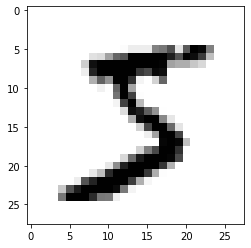

In [5]:
# Display an image

digit = X[0]
digit_pic = digit.reshape(28,28)
plt.imshow(digit_pic,cmap = mpl.cm.binary,interpolation="nearest") 
y[0]

In [6]:
# Train test split

X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [7]:
# Binary classifier to classify each image as 5 or not 5
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.base import clone

y_train_5 = (y_train==5)
y_test_5 = (y_test==5)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)
print(sgd_clf.predict([digit]))

# Cross validation
# skfolds = StratifiedKFold(n_splits=3,random_state=42)

# for train_index,test_index in skfolds.split(X_train,y_train_5):
#   clone_clf = clone(sgd_clf)
#   X_train_folds = X_train[train_index]
#   y_train_folds = y_train_5[train_index]
#   X_test_fold = X_train[test_index]
#   y_test_fold = y_train_5[test_index]

#   clone_clf.fit(X_train_folds,y_train_folds)
#   y_pred = clone_clf.predict(X_test_fold)
#   n_correct = sum(y_pred == y_test_fold)
#   print(n_correct/len(y_pred))

# sklearn function for cross validation score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')


[ True]


array([0.95035, 0.96035, 0.9604 ])

In [8]:
# Confusion matrix to evaluate performance. It is better than using accuracy as a parameter
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score,recall_score

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
y_train_pred.shape
confusion_matrix(y_train_5,y_train_pred)
print(precision_score(y_train_5,y_train_pred))
print(recall_score(y_train_5,y_train_pred))

0.8370879772350012
0.6511713705958311


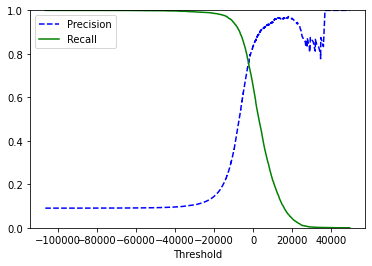

In [15]:
# Precision vs Recall
from sklearn.metrics import precision_recall_curve

def plot_precision_vs_recall(precisions,recalls,thresholds):
  plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
  plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
  plt.xlabel("Threshold")
  plt.legend(loc="upper left")
  plt.ylim([0,1])
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)
plot_precision_vs_recall(precisions,recalls,thresholds)
plt.show()

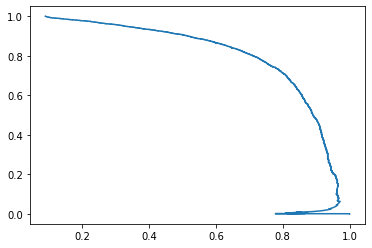

In [17]:
plt.plot(precisions,recalls)

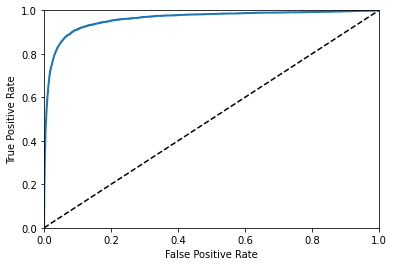

0.9604938554008616

In [21]:
# ROC curve
from sklearn.metrics import roc_curve,roc_auc_score
def plot_roc_curve(fpr,tpr,label=None):
  plt.plot(fpr,tpr,linewidth=2,label=label)
  plt.plot([0,1],[0,1],'k--')
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)
plot_roc_curve(fpr,tpr)
plt.show() 
roc_auc_score(y_train_5,y_scores)   # Higher the better